### Setup imports

In [97]:
!uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

Using Python 3.12.8 environment at: C:\Users\jesse\Documents\TU Delft\MSE git\img_classification\.venv
Audited 2 packages in 7ms


In [98]:
import os
import time
import torch
import torch.nn as nn
import numpy
import kornia.augmentation as K
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random as rnd

# Log if CUDA is available
print(torch.cuda.is_available())

True


> Module with common training functions

In [99]:
# Path the toe EuroSAT RGB dataset
DATASET_PATH = os.path.join(os.getcwd(), "../training_data/EuroSAT_RGB")

# Dataset and transforms the data to a tensor
dataset_full = datasets.ImageFolder(
	root=DATASET_PATH, transform=transforms.Compose([transforms.ToTensor()])
)


class ModelSplit:
	def __init__(self, dataset, test_size, batch_size):
		# Get the index for the training and validation sets
		train_idx, val_idx = train_test_split(
			range(len(dataset)),
			test_size=test_size,
			stratify=dataset.targets,  # Ensure the class distribution is preserved
		)

		# Create the training and validation set to pass to the loaders
		self.dataset_train = Subset(dataset, train_idx)
		self.dataset_val = Subset(dataset, val_idx)

		# TODO: Investigate if the DataLoader should shuffle the data
		self.loader_train = DataLoader(self.dataset_train, batch_size, shuffle=False)
		self.loader_val = DataLoader(self.dataset_val, batch_size, shuffle=False)


class Trainer:
	def __init__(self, model, weights, dataset):
		self.model = model
		# Set the amount of classes
		self.model.fc = nn.Linear(self.model.fc.in_features, dataset.num_classes)
		self.preprocess = weights.transforms()

		self.train_dataset = dataset
		self.validate_dataset = dataset
		self.test_dataset = dataset

		self.loss = nn.CrossEntropyLoss()
		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

		# Check if GPU is available
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		# Transfer model to device
		self.model = self.model.to(self.device)

	def train(self):
		return

> Module with distortion utilities

In [100]:
# Image rotation pipeline
def apply_rotation(image_tensor, angles={-45, 45}, probability=1):
	"""
	Apply a random rotation. If single value is given it is [-degrees,degrees] Otherwise range can be specified, p is the probability to rotate at all
	"""
	# Tensor transformation kernel
	transform = nn.Sequential(K.RandomRotation(degrees=angles, p=probability))
	# Apply kernel to image and return
	transformed_image = transform(image_tensor.unsqueeze(0))  # Add batch dimension
	return transformed_image.squeeze(0)  # Remove batch dimension


# Image horizontal flip pipeline
def apply_horizontalflip(image_tensor, probability=1):
	"""
	p is the probability to flip
	"""
	transform = torch.nn.Sequential(K.RandomHorizontalFlip(p=probability))
	transformed_image = transform(image_tensor.unsqueeze(0))  # Add batch dimension
	return transformed_image.squeeze(0)  # Remove batch dimension


# Image color jitter pipeline
def apply_colorjitter(image_tensor, probability=1):
	# Define a sequence of transformations
	transform = torch.nn.Sequential(
		K.ColorJitter(brightness=[2, 2], contrast=0.2, saturation=0.2, hue=0.1, p=probability)
	)
	# Apply transformations
	transformed_image = transform(image_tensor.unsqueeze(0))  # Add batch dimension
	return transformed_image.squeeze(0)  # Remove batch dimension


# Image Geometric transformation pipeline
def apply_geotransformations(
	image_tensor,
	rotAngles=[-45, 45],
	translate=[0.25, 0.25],
	scale=[0.75, 1.25],
	shearAngles=[-45, 45],
	probability=1,
	padding="zeros",
):
	"""
	rotAngles are angles for rotation, either single value to specify range, or give the complete range
	translate specifies the max x and y translation allowed, the number signifies the percentage of movement allowed
	scale scales the image between min and max, the number is the percentage of scaling allowed
	shearAngles are the angles for shearing of the image

	p is the probability to flip

	padding defines the padding mode, options are: "zeros" for black, "border" extends pixels to border, "reflection" this will reflect the image
	"""
	if type(rotAngles) == int or type(rotAngles) == float:
		rotAngles = [-rotAngles, rotAngles]
	if type(translate) == int or type(translate) == float:
		translate = [translate, translate]
	if type(scale) == int or type(scale) == float:
		scale = [scale, scale]
	if type(shearAngles) == int or type(shearAngles) == float:
		shearAngles = [-shearAngles, shearAngles]
	transform = torch.nn.Sequential(
		K.RandomAffine(
			degrees=rotAngles,
			translate=translate,
			scale=scale,
			shear=shearAngles,
			p=probability,
			padding_mode=padding,
		)
	)
	# Apply transformations
	transformed_image = transform(image_tensor.unsqueeze(0))  # Add batch dimension
	return transformed_image.squeeze(0)  # Remove batch dimension


# Image shift transformation pipeline
def apply_shift_image(image, num_rows, start_row):
	"""
	Removes a specified number of rows starting from a given row (start_row)
	and adds an equal number of black rows to the top.
	This simulates velocity variations

	Parameters:
	- image: Input image (PyTorch tensor of shape CxHxW, normalized to [0, 1]).
	- num_rows: Number of rows to remove from the image.
	- start_row: Row index from which to start removing rows.

	Returns:
	- Transformed image as a PyTorch tensor.
	"""

	c, h, w = image.shape

	# Validate inputs
	if start_row < 0 or start_row >= h:
		raise ValueError(f"The starting row ({start_row}) is outside of the image height ({h}).")
	if start_row + num_rows > h:
		raise ValueError(
			f"Removing {num_rows} rows from row {start_row} exceeds image height ({h})."
		)

	if num_rows < 0:  # skips lines due to velocity too high, created black region
		# Create a black padding tensor
		num_rows = abs(num_rows)
		repeat = int(num_rows / 60) + 2
		black_rows = torch.zeros(
			(c, num_rows * (repeat - 1), w), dtype=image.dtype, device=image.device
		)

		top_part = image[:, :start_row, :]  # Rows before start_row
		bottom_part = image[
			:, start_row + (num_rows * repeat) :, :
		]  # Rows after start_row + num_rows
		for i in range(0, num_rows):
			row_include = image[:, start_row + (i * repeat) : start_row + (i * repeat) + 1, :]
			top_part = torch.cat([top_part, row_include], dim=1)

		# Combine the remaining parts and add black rows at the top
		cropped_image = torch.cat([top_part, bottom_part], dim=1)
		transformed_image = torch.cat([cropped_image, black_rows], dim=1)
		transformed_image = transformed_image[:, :64, :]

		return transformed_image
	elif num_rows > 0:  # adds lines due to velocity too low
		# Take both sections with a row of overlap
		repeat = int(num_rows / 60) + 1
		top_part = image[:, :start_row, :]  # Rows before start_row
		bottom_part = image[
			:, start_row + (num_rows * repeat) :, :
		]  # Rows after start_row + num_rows
		for i in range(0, num_rows):
			repeat = int(num_rows / 60) + 1
			# row_copy = image[:, start_row+(i*repeat):start_row+(i*repeat)+1, :] # This is basically instrument breaking down
			row_copy = image[:, start_row + i : start_row + i + 1, :]
			while repeat > 0:
				repeat_image = torch.cat([top_part, row_copy], dim=1)
				top_part = repeat_image
				repeat -= 1

		# Combine the remaining parts and add black rows at the top
		cropped_image = torch.cat([repeat_image, bottom_part], dim=1)
		transformed_image = cropped_image[:, :64, :]

		return transformed_image
	else:
		return image


# Earth curvature simulation transformation pipeline
def apply_earth_curvature(image, curvature=0.01, padding="zeros"):
	"""
	Simulates the effect of Earth's curvature on an image.

	Parameters:
	- image: Input image (PyTorch tensor of shape CxHxW, normalized to [0, 1]).
	- curvature: The curvature factor; higher values increase the curvature effect.

	Returns:
	- Transformed image with simulated Earth's curvature.
	"""

	c, h, w = image.shape

	# Create a grid of coordinates
	y, x = torch.meshgrid(torch.linspace(-1, 1, h), torch.linspace(-1, 1, w), indexing="ij")
	y, x = y.to(image.device), x.to(image.device)

	# Apply curvature transformation (parabolic distortion)
	x_curved = x - curvature * (y**2)
	y_curved = y - curvature * (x**2)

	# Normalize the coordinates to [-1, 1] for Kornia's remap function
	map_x = (2 * x_curved / (w - 1)) - 1  # Normalize x to [-1, 1]
	map_y = (2 * y / (h - 1)) - 1  # Normalize y to [-1, 1]

	# # Debug: Visualize the y_curved grid
	# if curvature > 0:
	#     plt.imshow(y_curved.cpu().numpy(), cmap="viridis")
	#     plt.title("Curved Y Grid")
	#     plt.colorbar()
	#     plt.show()

	# Ensure map_x and map_y have batch dimension [B, H, W]
	map_x = x.unsqueeze(0)  # Add batch dimension
	map_y = y_curved.unsqueeze(0)  # Add batch dimension

	# Apply the transformation using remap
	transformed_image = kornia.geometry.transform.remap(
		image.unsqueeze(0),
		map_x,
		map_y,
		align_corners=True,
		normalized_coordinates=True,
		padding_mode=padding,
	)
	return transformed_image.squeeze(0)

### Load datasets

In [101]:
BATCH_SIZE = 1500
# Seems to work okay on the RPI
BATCH_SIZE_TEST = 20
TEST_SIZE = 0.2
EPOCHS = 10

# To skip training or not, training can only be skipped if the model.pth file is present
skip_training = True

In [102]:
data = ModelSplit(dataset_full, 0.2, BATCH_SIZE)


# Split into training and validation set
train_idx, val_idx = train_test_split(
	range(len(dataset_full)),  # Size of the full dataset
	test_size=TEST_SIZE,  # Fraction used for validation (test)
	stratify=dataset_full.targets,  # Ensure class distribution is preserved
)
# Create the full dataset


# Create the training and validation set
dataset_train = Subset(dataset_full, train_idx)
dataset_val = Subset(dataset_full, val_idx)

# TODO: Investigate if the DataLoader should shuffle the data
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

# Show all the class labels
print(dataset_full.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Set Model

In [103]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Adjust to the amount of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset_full.classes))

### Setup Training

In [104]:
# Set up loss function
loss = torch.nn.CrossEntropyLoss()

# Set up optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


### Model Training

In [105]:
# Track time
start_time = time.time()

if not (skip_training):
	# Holder for training loss
	train_loss_list = []
	# Holder for validation loss
	validation_loss_list = []

	for epoch in tqdm(range(EPOCHS), desc="Epochs"):
		# Setup model to perform training
		model.train()

		loss_train = 0
		# Number of correct predictions for train split
		train_correct = 0
		# Number of total predictions for train split
		train_total = 0

		# Perform training in batches
		for inputs, labels in tqdm(loader_train, desc="Training - batch"):
			# Move data to device (CPU or GPU)
			inputs, labels = inputs.to(device), labels.to(device)

			# Zero the gradients
			optimizer.zero_grad()
			# Calculate the predictions (outputs) on the batch
			outputs = model(inputs)
			# Calculate the loss (error) between predictions and labels
			train_loss = loss(outputs, labels)
			# Back propagate the error and update the weights
			train_loss.backward()
			# Update the weights using the SGD optimizer
			optimizer.step()
			# Extract the predicted class
			predicted = torch.max(outputs, 1)[1]
			# Update the total and number of correct
			train_correct += (predicted == labels).sum().item()
			train_total += labels.size(0)

		# Calculate the training accuracy
		train_acc = 100.0 * train_correct / train_total

		train_loss_list.append(train_loss)

		# Setup model to perform validation (inference)
		model.eval()

		# Number of correct predictions for validation split
		val_correct = 0
		# Number of total predictions for validation split
		val_total = 0

		# Validate model using the validation set, the gradients do not need to be calculated
		with torch.no_grad():
			for inputs, labels in tqdm(loader_val, desc="Validation - batch"):
				# Move data to device (CPU or GPU)
				inputs, labels = inputs.to(device), labels.to(device)

				# Calculate the predictions (outputs) on the batch
				outputs = model(inputs)
				# Calculate the loss (error) between predictions and labels
				val_loss = loss(outputs, labels)
				# Extract the predicted class
				predicted = torch.max(outputs, 1)[1]
				# Update the total and number of correct
				val_correct += (predicted == labels).sum().item()
				val_total += labels.size(0)

			# Calculate the validation accuracy
			val_acc = 100.0 * val_correct / val_total

			# Append validation loss values
			validation_loss_list.append(val_loss)

		# Print Epoch information
		print(f"Epoch: {epoch + 1}/{EPOCHS}")
		print(f"Train loss: {train_loss:.4f}")
		print(f"Train accuracy: {train_acc:.2f}%")
		print(f"Validation loss: {val_loss:.4f}")
		print(f"Validation accuracy: {val_acc:.2f}%")

	# Saving the model
	torch.save(model.state_dict(), "model.pth")
	print("Model trained")
	# Save the training and validation loss
	torch.save((train_loss_list, validation_loss_list), "losses.pth")
	# with open('train_loss.pkl', 'wb') as f:
	#   pickle.dump((train_loss_list, validation_loss_list), f)
	print("Losses saved")
else:
	print("Skip training...")
	try:
		model.load_state_dict(torch.load("model.pth", weights_only=True, map_location=device))
		print("Model loaded")
	except FileNotFoundError:
		print("Model not found")

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Skip training...
Model loaded
Elapsed time: 0.12 seconds


### Plot losses over training epochs

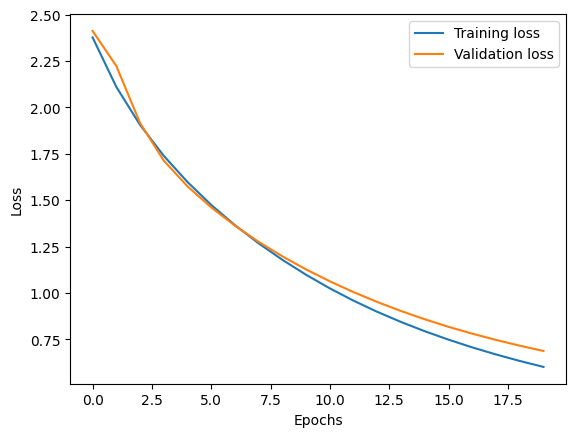

In [106]:
# Load losses from file if no training is performed
if skip_training:
	train_loss_list, validation_loss_list = torch.load(
		"losses.pth", weights_only=True, map_location=device
	)

# Built a plot of the losses over the training epochs, move the data to the CPU for matplotlib
if torch.is_tensor(train_loss_list[0]):
	train_loss_list = [float(x.detach().cpu()) for x in train_loss_list]

if torch.is_tensor(validation_loss_list[0]):
	validation_loss_list = [float(x.detach().cpu()) for x in validation_loss_list]

plt.plot(train_loss_list, label="Training loss")
plt.plot(validation_loss_list, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Distort the test data

In [ ]:
SHIFT = True
GEOTRANSFORM = True
CURVATURE = True

PROBABILITY_GEO = 1
PADDING = "reflection"


# Create a custom dataset where images are distorted on-demand
class DistortedDataset(Dataset):
	def __init__(self, dataset):
		self.dataset = dataset

	def __len__(self):
		return len(self.dataset)

	def __getitem__(self, idx):
		image, label = self.dataset[idx]

		# Apply transformation pipelines, transformation data is kept with images
		# Shift transformation
		if rnd.randrange(0, 99) <= 33 and SHIFT:  # adds a probability factor
			num = rnd.randrange(-62, 62)
			start = rnd.randrange(0, 63 - abs(num))
			image = apply_shift_image(image, num_rows=num, start_row=start)
			# print(image.shape)
		else:
			start = 0
			num = 0

		# Geometric transformation
		if GEOTRANSFORM:
			rot = rnd.randrange(-100, 100, step=1) / 10
			tran = rnd.randrange(0, 10, step=1) / 100
			scale = rnd.randrange(80, 120, step=1) / 100
			shear = rnd.randrange(-50, 50, step=1) / 10
			image = apply_geotransformations(
				image,
				rotAngles=[rot, rot],
				translate=[tran, tran],
				scale=[scale, scale],
				shearAngles=[shear, shear],
				probability=PROBABILITY_GEO,
				padding=PADDING,
			)
		else:
			rot = 0
			tran = 0
			scale = 0
			shear = 0

		# Curvature transformation
		if CURVATURE:
			curv = rnd.randrange(0, 100) / 1000
			image = apply_earth_curvature(image, curvature=curv, padding=PADDING)
		else:
			curv = 0

		# Return tuple with distortion metadata
		return image, label, (start, num, rot, tran, scale, shear, curv)


dataset_distorted = DistortedDataset(dataset_full)

loader_test = DataLoader(dataset_distorted, batch_size=BATCH_SIZE_TEST, shuffle=True)

### Measure on the distorted images

In [ ]:
# Set model to evaluation mode
model.eval()

# Number of correct predictions for test split
test_correct = 0
# Number of total predictions for test split
test_total = 0

predictions = []
targets = []
images = []

# Evaluate model on the test set
with torch.no_grad():
	# Split into batches
	for inputs, labels, _ in tqdm(loader_test, desc="Test - batched"):
		# Move data to device (CPU or GPU)
		inputs, labels = inputs.to(device), labels.to(device)

		# Calculate the predictions (outputs) on the batch
		outputs = model(inputs)
		predicted = torch.max(outputs, 1)[1]
		# Update the total and number of correct
		test_correct += (predicted == labels).sum().item()
		test_total += labels.size(0)
		# Store the predictions and targets
		predictions += list(predicted)
		targets += list(labels)
		images += list(inputs)

	# Calculate the test accuracy
	test_accuracy = 100.0 * test_correct / test_total

print(f"Test accuracy: {test_accuracy:.4f}%")

# Move predictions, targets and images to the CPU for matplotlib
predictions = [x.detach().cpu().numpy() for x in predictions]
targets = [x.detach().cpu().numpy() for x in targets]
images = [x.detach().cpu().numpy() for x in images]

Test - batched:   0%|          | 0/1350 [00:00<?, ?it/s]

Test accuracy: 0.7194%


### Show predictions on random images

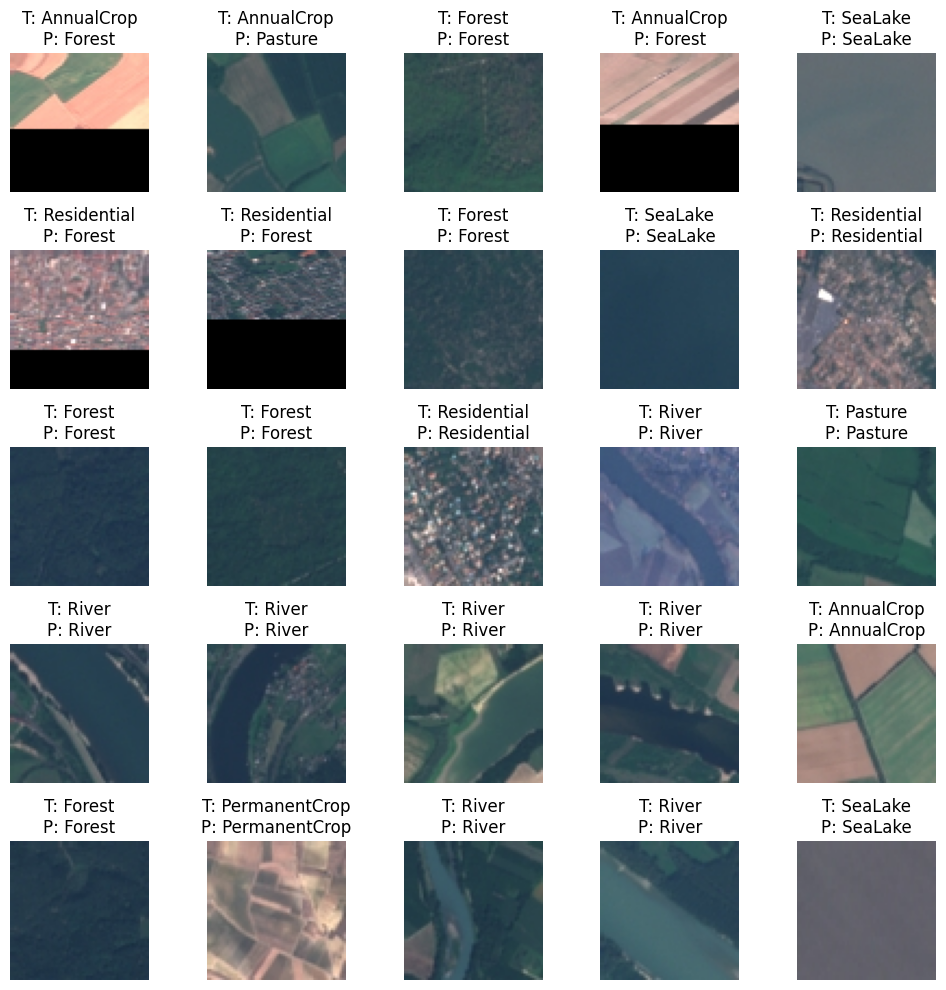

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
	ax = axes[i // 5, i % 5]
	ax.imshow(numpy.moveaxis(images[i], 0, -1))
	ax.set_title(
		f"T: {dataset_full.classes[targets[i]]}\nP: {dataset_full.classes[predictions[i]]}"
	)
	ax.axis("off")
plt.tight_layout()